<a href="https://colab.research.google.com/github/jnctproject/pytorch-tutorial/blob/main/cnn_model_for_pressure_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50, Loss: 542.0898
Epoch 2/50, Loss: 9.8415
Epoch 3/50, Loss: 4.8338
Epoch 4/50, Loss: 3.8860
Epoch 5/50, Loss: 2.0821
Epoch 6/50, Loss: 1.4404
Epoch 7/50, Loss: 1.0835
Epoch 8/50, Loss: 1.2022
Epoch 9/50, Loss: 0.7212
Epoch 10/50, Loss: 1.1758
Epoch 11/50, Loss: 0.8137
Epoch 12/50, Loss: 0.6085
Epoch 13/50, Loss: 0.5101
Epoch 14/50, Loss: 0.6039
Epoch 15/50, Loss: 0.5882
Epoch 16/50, Loss: 0.3942
Epoch 17/50, Loss: 0.2153
Epoch 18/50, Loss: 0.1309
Epoch 19/50, Loss: 0.1937
Epoch 20/50, Loss: 0.1579
Epoch 21/50, Loss: 0.1293
Epoch 22/50, Loss: 0.1364
Epoch 23/50, Loss: 0.1357
Epoch 24/50, Loss: 0.1058
Epoch 25/50, Loss: 0.0942
Epoch 26/50, Loss: 0.0961
Epoch 27/50, Loss: 0.0554
Epoch 28/50, Loss: 0.0663
Epoch 29/50, Loss: 0.0761
Epoch 30/50, Loss: 0.0788
Epoch 31/50, Loss: 0.0757
Epoch 32/50, Loss: 0.1007
Epoch 33/50, Loss: 0.1261
Epoch 34/50, Loss: 0.0537
Epoch 35/50, Loss: 0.0703
Epoch 36/50, Loss: 0.0429
Epoch 37/50, Loss: 0.0399
Epoch 38/50, Loss: 0.0515
Epoch 39/50, Loss: 

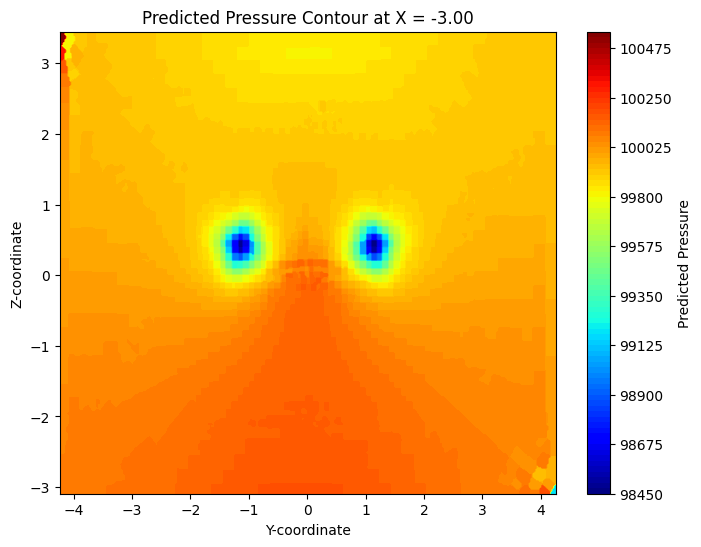

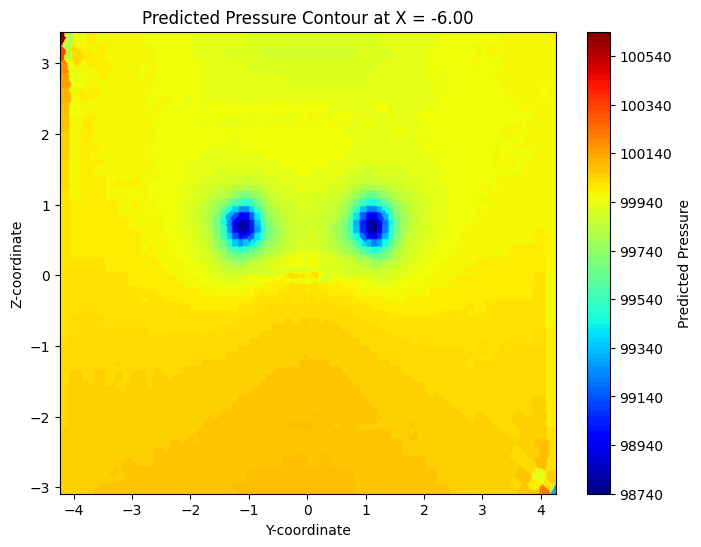

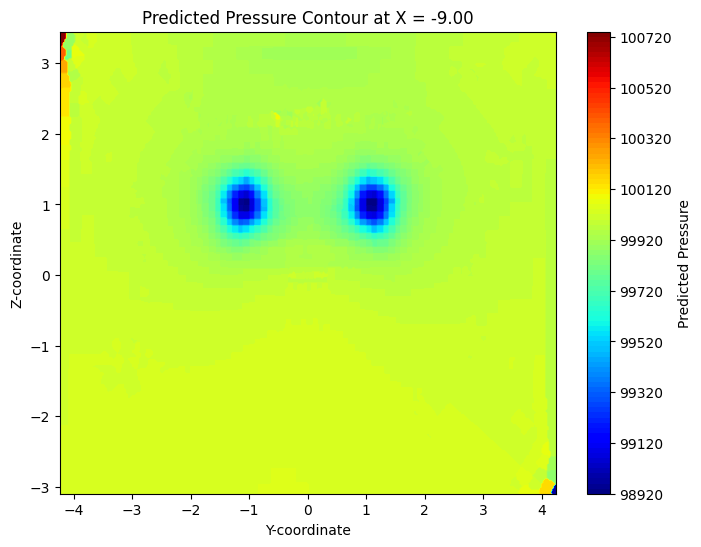

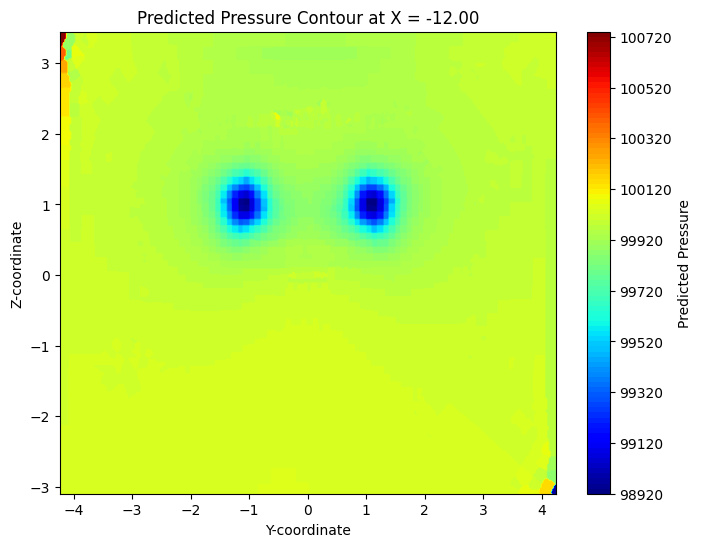

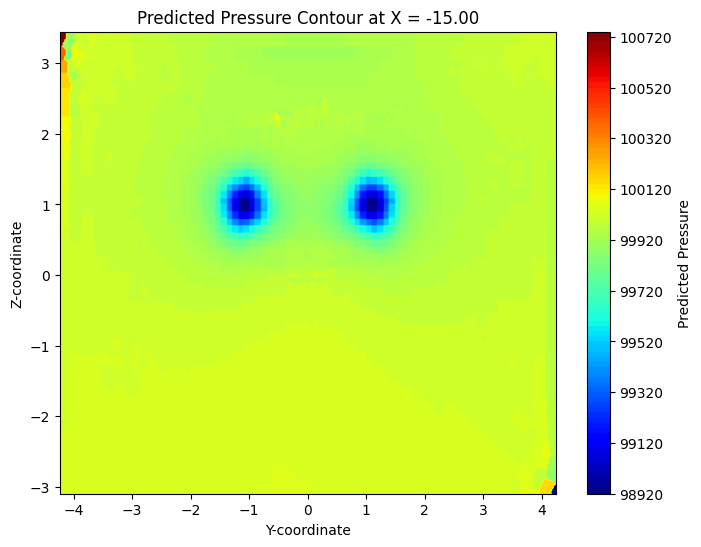

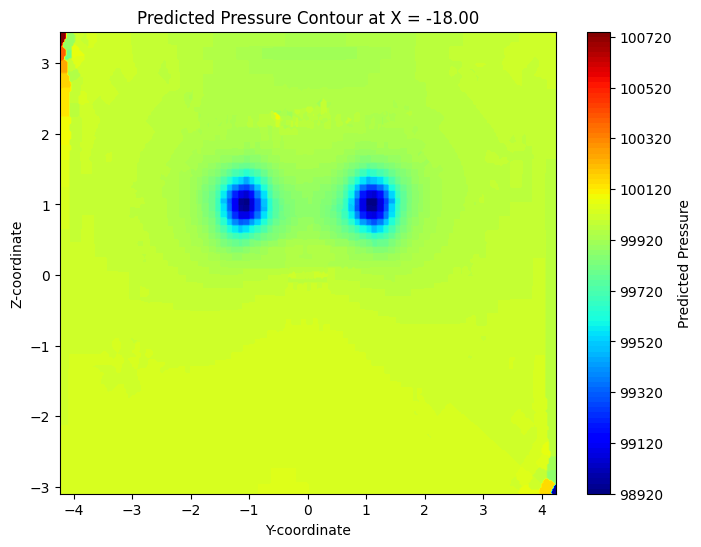

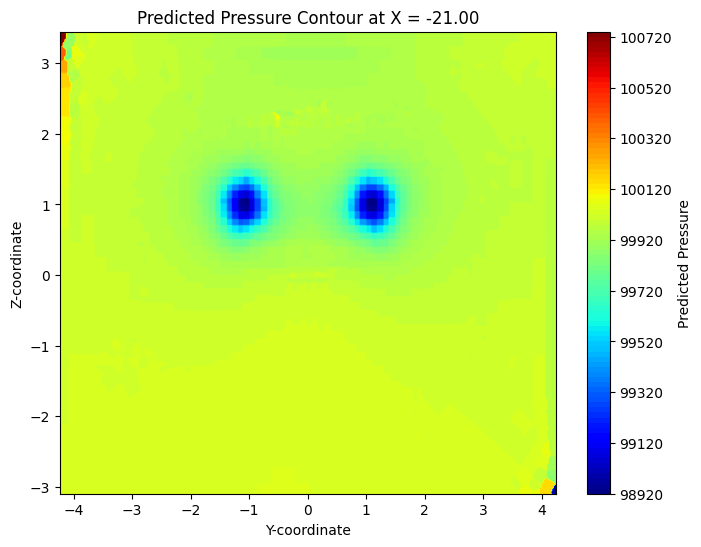

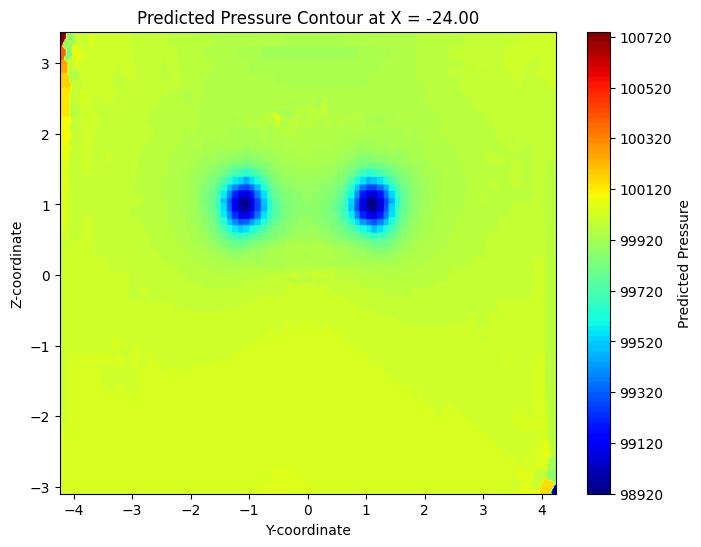

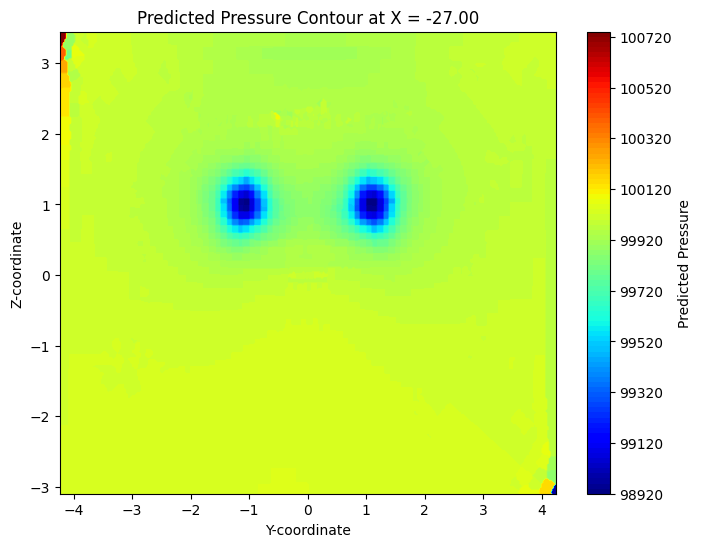

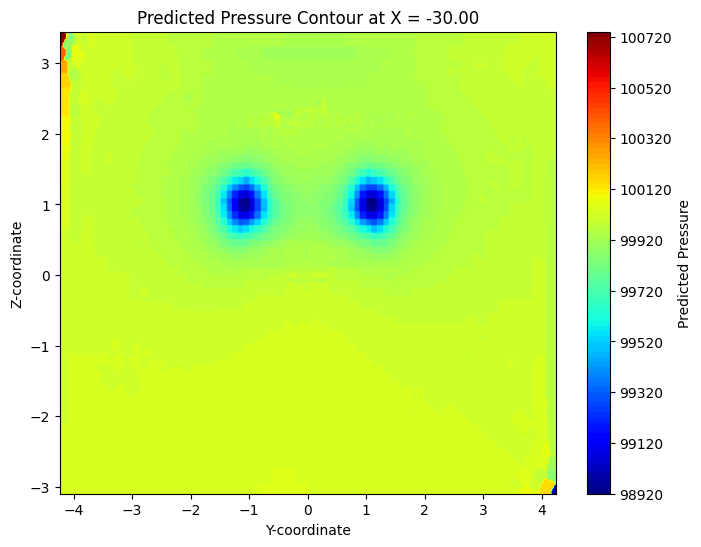

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define file paths
file_paths = [

    "m1data.dat",

]

# Data processing
images, labels = [], []
coordinates, pressures = [], []

for file_path in file_paths:
    df = pd.read_csv(file_path, delimiter='\s+', header=0)
    x_values = np.sort(df['x-coordinate'].unique())[::-1]

    for x1 in x_values:
        # Increased tolerance to 1e-3 and added check for finite values:
        mask = np.isclose(df['x-coordinate'], x1, atol=1e-3) & np.isfinite(df['x-coordinate'])

        # Check if mask is empty:
        if not mask.any():
            print(f"Warning: No data points found for x-coordinate: {x1}, skipping...")
            continue  # Skip to the next iteration if mask is empty

        y, z, pressure = df.loc[mask, 'y-coordinate'], df.loc[mask, 'z-coordinate'], df.loc[mask, 'pressure']

        coordinates.append((x1, y.values, z.values))
        pressures.append(pressure.values)

        y_unique = np.linspace(y.min(), y.max(), 300)
        z_unique = np.linspace(z.min(), z.max(), 300)
        Y, Z = np.meshgrid(y_unique, z_unique)

        pressure_grid = griddata((y, z), pressure, (Y, Z), method='cubic')
        if np.isnan(pressure_grid).sum() > 0:
            pressure_grid = griddata((y, z), pressure, (Y, Z), method='nearest')

        pressure_grid = (pressure_grid - np.min(pressure_grid)) / (np.max(pressure_grid) - np.min(pressure_grid))
        image = pressure_grid.reshape((1, 300, 300))

        images.append(image)
        labels.append(x1)

X_data = torch.tensor(np.array(images), dtype=torch.float32)
y_data = torch.tensor(np.array(labels), dtype=torch.float32)
y_min, y_max = y_data.min(), y_data.max()
y_data = (y_data - y_min) / (y_max - y_min)

# Define Dataset class
class PressureDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = PressureDataset(X_data, y_data)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = CNNModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch).squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Convert predictions back to original scale
all_preds = np.array(all_preds) * (y_max.cpu().numpy() - y_min.cpu().numpy()) + y_min.cpu().numpy()
all_labels = np.array(all_labels) * (y_max.cpu().numpy() - y_min.cpu().numpy()) + y_min.cpu().numpy()
print("Predictions:", all_preds[:10])
print("Actual:", all_labels[:10])

# Assign y_test (Assuming all_labels represents the test labels)
y_test = torch.tensor(all_labels) # Convert to tensor if required

# Plot Predicted Pressure Contours
x_values = np.linspace(-3, -30, 10)
for x_pred in x_values:
    closest_index = np.argmin([abs(x1 - x_pred) for x1, _, _ in coordinates])
    _, y_vals, z_vals = coordinates[closest_index]
    pressure_vals = pressures[closest_index]

    y_grid = np.linspace(min(y_vals), max(y_vals), 300)
    z_grid = np.linspace(min(z_vals), max(z_vals), 300)
    Y_grid, Z_grid = np.meshgrid(y_grid, z_grid)

    pressure_interp = griddata((y_vals, z_vals), pressure_vals, (Y_grid, Z_grid), method='cubic')
    if np.isnan(pressure_interp).sum() > 0:
        pressure_interp = griddata((y_vals, z_vals), pressure_vals, (Y_grid, Z_grid), method='nearest')

    plt.figure(figsize=(8, 6))
    plt.contourf(Y_grid, Z_grid, pressure_interp, levels=100, cmap='jet')
    plt.colorbar(label='Predicted Pressure')
    plt.xlabel('Y-coordinate')
    plt.ylabel('Z-coordinate')
    plt.title(f'Predicted Pressure Contour at X = {x_pred:.2f}')
    plt.show()
